# XGBoost 로 feature importance 분석하기
- [노션 정리 내용](https://watchstep.notion.site/feature-importance-permutation-importance-79a6e99251fb4fc4a150e8998cbb2534)

- 수행 이유
    - feature importance 를 통해 성능을 개선하기 위함
    - 또한 category와 book_title, author, publisher 와의 관계를 파악하여 imputation 순서를 정하기 위함
    - `가정: category의 importance가 높을 것 같음`
- 수행 방법
    - XGBoost Regressor 모델의 feature importance 파악
    - sklearn의 permutation_importance 사용
    - shap 사용
- 결과 요약
    - language의 importance가 매우 높았는데, 이는 language가 low cardinality feature기 때문
    - language를 feature에서 제거하니 오히려 전체적인 성능이 좋아짐

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce
import xgboost as xgb

In [2]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

## original data 분석하기

In [3]:
# 경로 지정 후 불러오기 
base_path = os.path.join(os.curdir, 'data')
user_path = os.path.join(base_path, 'users.csv') # original 데이터
book_path = os.path.join(base_path, 'books.csv') # original 데이터
rating_path = os.path.join(base_path, 'train_ratings.csv')

In [4]:
users = pd.read_csv(user_path, encoding='utf-8')
books = pd.read_csv(book_path, encoding='utf-8')
ratings = pd.read_csv(rating_path, encoding='utf-8')

In [5]:
# 데이터 merge
merge_ = ratings.merge(books, how='left', on='isbn')
data = merge_.merge(users, how='inner', on='user_id')
print('data shape:', data.shape)

data shape: (306795, 14)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              306795 non-null  int64  
 1   isbn                 306795 non-null  object 
 2   rating               306795 non-null  int64  
 3   book_title           306795 non-null  object 
 4   book_author          306795 non-null  object 
 5   year_of_publication  306795 non-null  float64
 6   publisher            306795 non-null  object 
 7   img_url              306795 non-null  object 
 8   language             187711 non-null  object 
 9   category             185574 non-null  object 
 10  summary              187711 non-null  object 
 11  img_path             306795 non-null  object 
 12  location             306795 non-null  object 
 13  age                  214133 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 35.1+ MB


In [8]:
data.isnull().sum()

user_id                     0
isbn                        0
rating                      0
book_title                  0
book_author                 0
year_of_publication         0
publisher                   0
img_url                     0
language               119084
category               121221
summary                119084
img_path                    0
location                    0
age                     92662
dtype: int64

In [9]:
data.dropna(inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128626 entries, 7 to 306794
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              128626 non-null  int64  
 1   isbn                 128626 non-null  object 
 2   rating               128626 non-null  int64  
 3   book_title           128626 non-null  object 
 4   book_author          128626 non-null  object 
 5   year_of_publication  128626 non-null  float64
 6   publisher            128626 non-null  object 
 7   img_url              128626 non-null  object 
 8   language             128626 non-null  object 
 9   category             128626 non-null  object 
 10  summary              128626 non-null  object 
 11  img_path             128626 non-null  object 
 12  location             128626 non-null  object 
 13  age                  128626 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 14.7+ MB


### 'age'와 다른 columns 간 관계 파악하기

In [140]:
target = 'age'
y = data[target]
X = data.drop(columns=[target, 'isbn', 'img_url', 'summary', 'img_path', 'language'])

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [142]:
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_New = encoder.fit_transform(X_train, y_train)
X_test_New = encoder.transform(X_test)

In [ ]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
model.fit(X_train_New, y_train)

In [144]:
rmse = np.sqrt(mean_squared_error(y_test, model.predict(np.ascontiguousarray(X_test_New))))
rmse

11.077638055916546

Text(0.5, 1.0, 'Feature Importance')

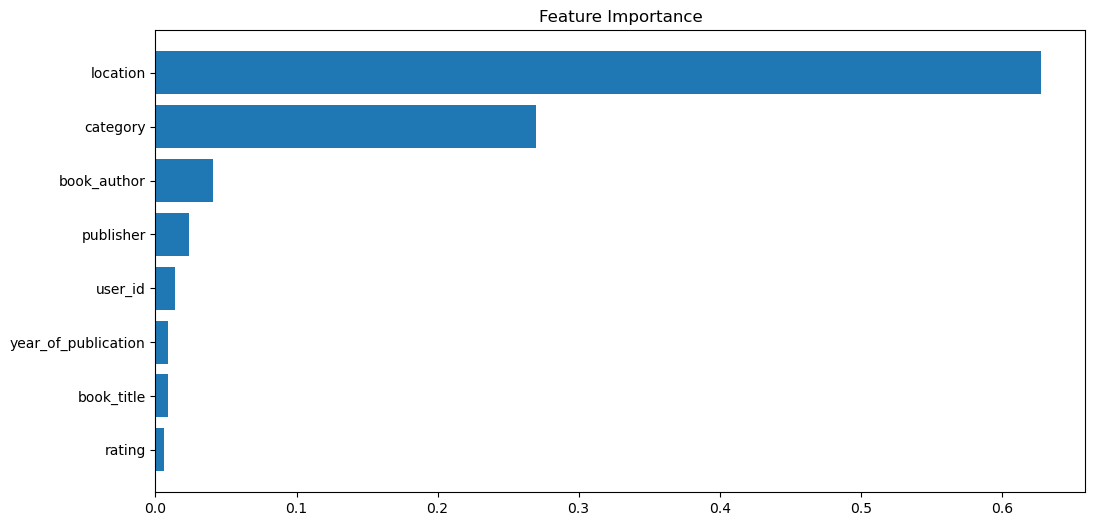

In [145]:
# Feature importance 
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'Permutation Importance')

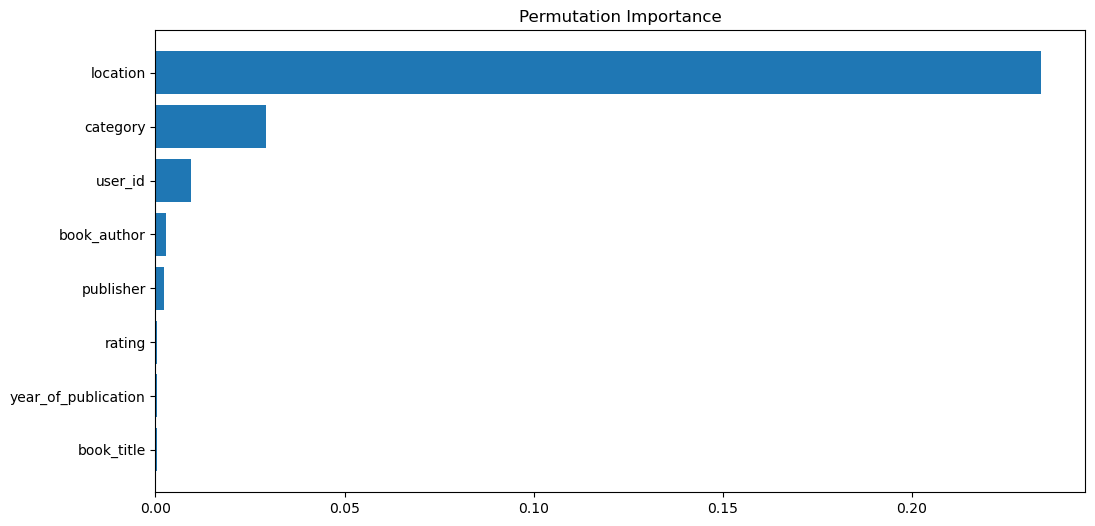

In [146]:
# Permutation Importance
perm_importance = permutation_importance(model, np.ascontiguousarray(X_test_New), y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Text(0.5, 1.0, 'SHAP Importance')

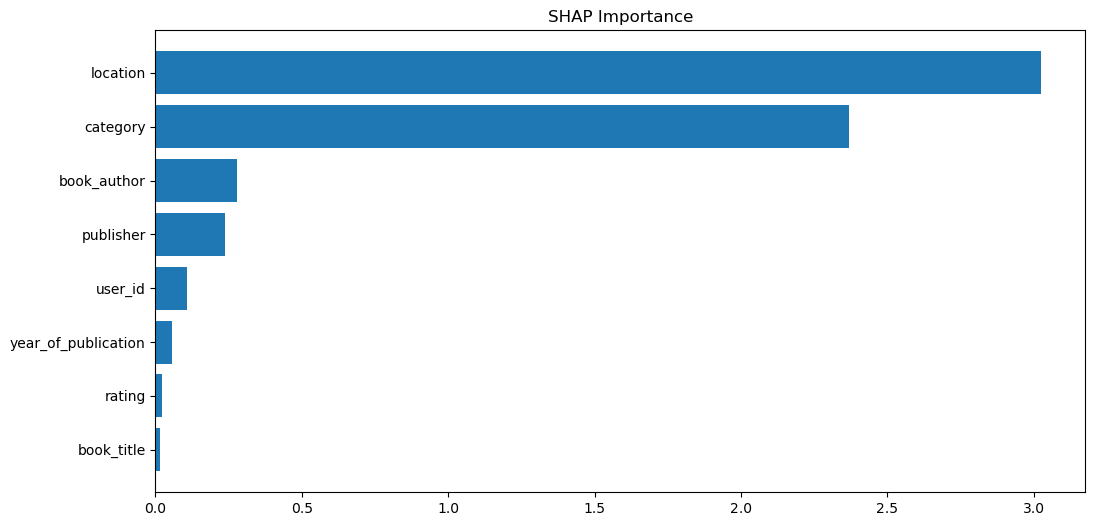

In [147]:
# SHAP Importance
explainer = shap.Explainer(model)
shap_values = explainer(np.ascontiguousarray(X_test_New))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')

## mission data로 분석하기

In [6]:
base_path = os.path.join(os.curdir, 'data')
merge_path = os.path.join(base_path, 'merge.csv')

In [7]:
mission_data = pd.read_csv(merge_path, encoding='utf-8')

In [161]:
mission_data.shape

(306795, 19)

In [162]:
mission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              306795 non-null  int64  
 1   isbn                 306795 non-null  object 
 2   rating               306795 non-null  int64  
 3   book_title           306795 non-null  object 
 4   book_author          306795 non-null  object 
 5   year_of_publication  306795 non-null  float64
 6   publisher            306795 non-null  object 
 7   img_url              306795 non-null  object 
 8   language             187711 non-null  object 
 9   category             185574 non-null  object 
 10  summary              187711 non-null  object 
 11  img_path             306795 non-null  object 
 12  category_high        149780 non-null  object 
 13  location             306795 non-null  object 
 14  age                  214133 non-null  float64
 15  location_city    

In [165]:
mission_data.isna().sum()

user_id                     0
isbn                        0
rating                      0
book_title                  0
book_author                 0
year_of_publication         0
publisher                   0
img_url                     0
language               119084
category               121221
summary                119084
img_path                    0
category_high          157015
location                    0
age                     92662
location_city            7008
location_state           8729
location_country         6577
age_range               92662
dtype: int64

In [166]:
# 필요하지 않은 columns 제거 (이것 저것 제거하면서 파악)
mission_data = mission_data.drop(columns=['img_url', 'summary', 'img_path', 'location', 'age'])
mission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              306795 non-null  int64  
 1   isbn                 306795 non-null  object 
 2   rating               306795 non-null  int64  
 3   book_title           306795 non-null  object 
 4   book_author          306795 non-null  object 
 5   year_of_publication  306795 non-null  float64
 6   publisher            306795 non-null  object 
 7   language             187711 non-null  object 
 8   category             185574 non-null  object 
 9   category_high        149780 non-null  object 
 10  location_city        299787 non-null  object 
 11  location_state       298066 non-null  object 
 12  location_country     300218 non-null  object 
 13  age_range            214133 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 32.8+ MB


In [167]:
mission_data.dropna(inplace=True)

In [178]:
mission_data.shape

(102243, 14)

In [169]:
mission_data.nunique()

user_id                22491
isbn                   41614
rating                    10
book_title             39167
book_author            19439
year_of_publication       79
publisher                645
language                  21
category                 679
category_high             43
location_city           6152
location_state           711
location_country         117
age_range                 10
dtype: int64

In [213]:
# target = 'rating' 으로 설정, importance 파악을 위한 변수는 X로 설정
target = 'rating'
y = mission_data[target]
X = mission_data.drop(columns=[target,'age_range','year_of_publication','user_id','book_title', 'category', 'isbn', 'location_city', 'location_state'])

In [214]:
X.nunique()

book_author         19439
publisher             645
language               21
category_high          43
location_country      117
dtype: int64

In [215]:
# train, test dataset으로 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [216]:
# encoding
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_New = encoder.fit_transform(X_train, y_train)
X_test_New = encoder.transform(X_test)

In [217]:
# XGBoost Regressor 사용 
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
model.fit(X_train_New, y_train)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(np.ascontiguousarray(X_test_New))))
rmse

2.3863801017406994

Text(0.5, 1.0, 'Feature Importance')

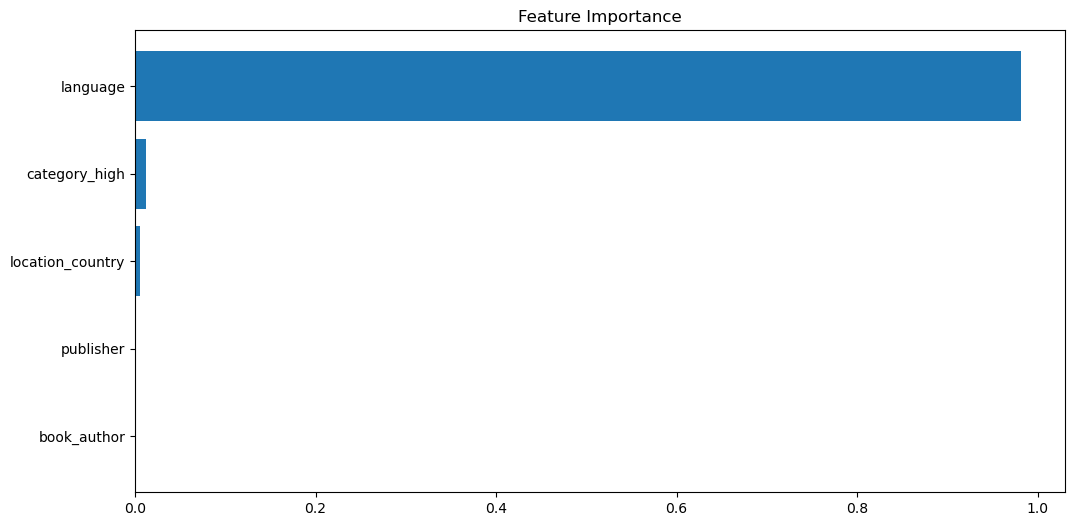

In [218]:
# feature importance
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'Permutation Importance')

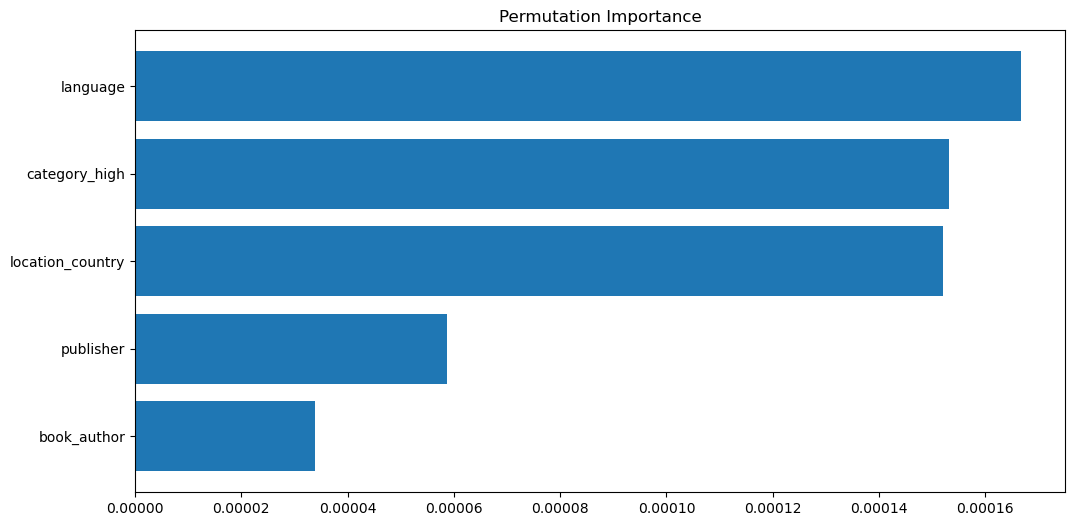

In [219]:
# permutation importance
perm_importance = permutation_importance(model, np.ascontiguousarray(X_test_New), y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Text(0.5, 1.0, 'SHAP Importance')

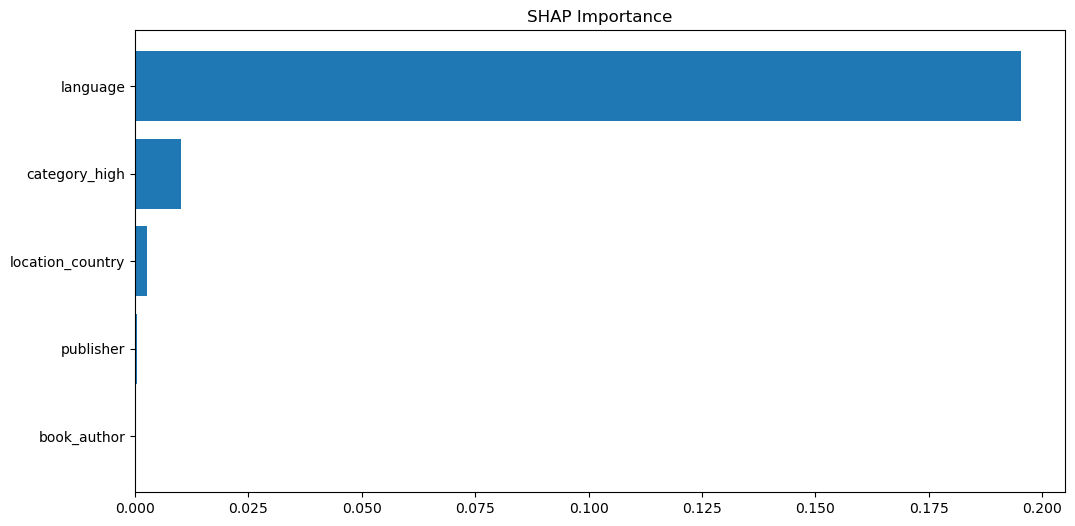

In [220]:
# SHAP importance
explainer = shap.Explainer(model)
shap_values = explainer(np.ascontiguousarray(X_test_New))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')

### language 별 rating 시각화
- language에 importance가 몰려있어서, language 별 분석이 필요해 보여서 수행
- seaborn을 사용한 시각화

In [226]:
mission_data.groupby('language')['rating'].describe().sort_values(by='count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
en,99922.0,7.212996,2.371751,1.0,6.00,8.0,9.00,10.0
es,1000.0,6.967000,2.287169,1.0,6.00,7.0,9.00,10.0
fr,563.0,7.174067,2.205195,1.0,6.00,8.0,9.00,10.0
de,509.0,6.996071,2.593144,1.0,6.00,8.0,9.00,10.0
it,171.0,7.549708,2.015130,1.0,7.00,8.0,9.00,10.0
ca,16.0,6.125000,2.500000,1.0,5.00,7.0,7.25,10.0
nl,15.0,6.200000,1.934647,1.0,6.00,6.0,7.00,9.0
da,10.0,7.500000,2.368778,4.0,6.00,8.0,9.75,10.0
ms,10.0,6.200000,2.859681,2.0,4.25,7.0,8.00,10.0


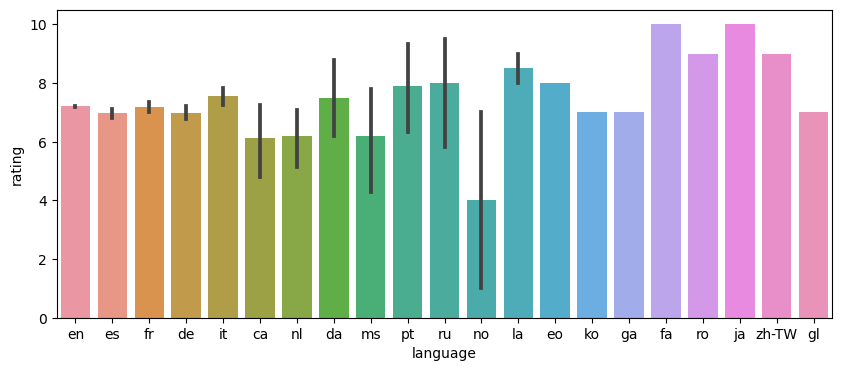

In [301]:
# language별 rating (count가 많은 순으로 정렬)
import seaborn as sns
lan_df = mission_data.groupby('language')['rating'].describe().sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(data=mission_data, x='language', y='rating', order = mission_data['language'].value_counts().index)
plt.show()

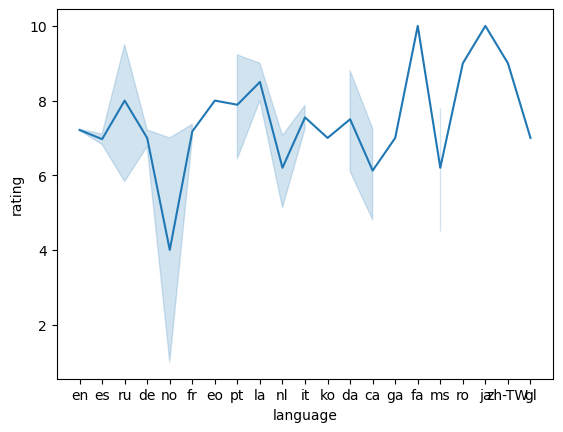

In [230]:
# language별 rating 파악 
sns.lineplot(data=mission_data, x='language', y='rating')
plt.show()



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



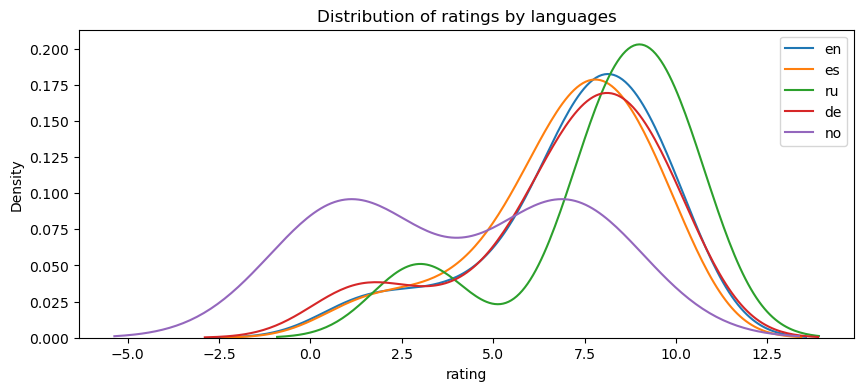

In [300]:
# language 별 rating 밀도 분포 파악
# 실제 데이터는 1 <= rating <= 10 임을 유의  
plt.figure(figsize=(10, 4))
for lan in mission_data['language'].unique().tolist()[:5]:
    subset = mission_data[mission_data['language']==lan]
    sns.distplot(subset['rating'],
                 hist=False,
                 kde=True,
                 kde_kws={'bw_method': 0.5},
                 label=lan)
plt.title("Distribution of ratings by languages")
plt.legend()
plt.show()